In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import pandas as pd
from scipy import constants

r =  1.4048115940347137e-06
temp = 293
rho = 4200
rho_f = 789
eta = 0.36e-3
mass = 4/3 *np.pi *r**3*rho + 2/3 *np.pi *r**3*rho_f

In [3]:
# SIMULATIONS

chunksize = 10 ** 6  # Adjust chunk size based on your memory availability
chunks = []

for chunk in pd.read_csv(r'C:\Users\mct2723\Desktop\Repos\MarkovianEmbedding\position_velocity_data.csv', chunksize=chunksize, low_memory=False):
    # process each chunk individually or filter/aggregate it
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

# Extract only the columns that start with 'Position' or 'Velocity'
position_cols = [col for col in df.columns if col.startswith('Position')]
velocity_cols = [col for col in df.columns if col.startswith('Velocity')]

timestep_sim = df['real_timestep_s'].values[0]
positions_sim = []
velocities_sim = []
for i in range(len(position_cols)):
    positions_sim.append(df[position_cols[i]].astype(float).values)
    velocities_sim.append(df[velocity_cols[i]].astype(float).values)

# print(f"Positions shape: {positions_sim.shape}")
# print(f"Velocities shape: {velocities_sim.shape}")

bin_num_sim = 40
fs_sim = 1/(timestep_sim * bin_num_sim)

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

traces_sim = []
for trace in positions_sim:
    series = bin_data(trace, bin_num_sim)
    traces_sim.append(series)

print("len of traces is " + str(len(traces_sim[0])))

v_traces_sim = []
for trace in velocities_sim:
    series = bin_data(trace, bin_num_sim)
    v_traces_sim.append(series)

len of traces is 446663


sqrt kT/m is 0.0002753498819746064
vel std is 0.0002753056355820447
4466
446663
length of history is 4466
length of trace is 446663
speed idx sim: 212
total hist idx: 211
len of gamma mean 211


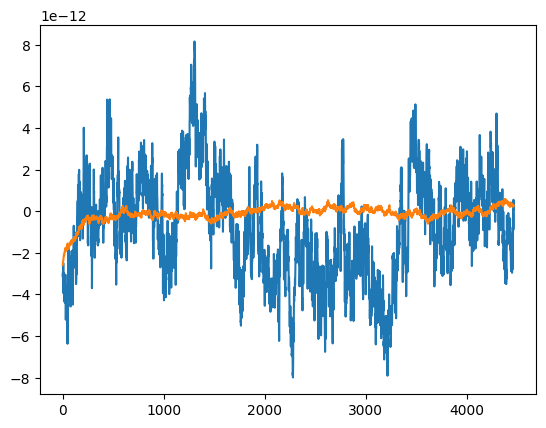

length of history is 4466
length of trace is 446663
speed idx sim: 307
total hist idx: 306
len of gamma mean 306


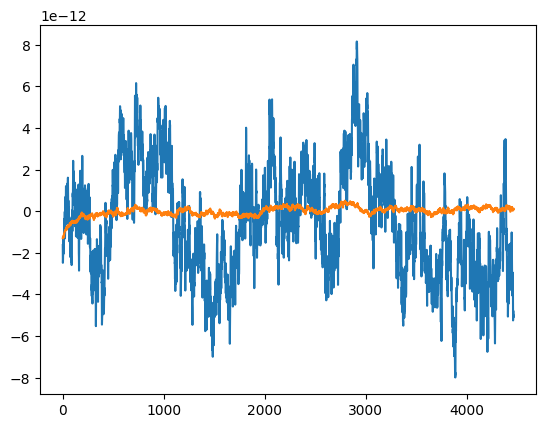

length of history is 4466
length of trace is 446663
speed idx sim: 363
total hist idx: 358
len of gamma mean 358


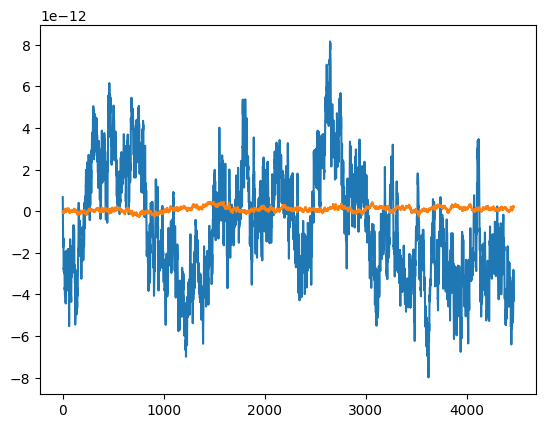

length of history is 4466
length of trace is 446663
speed idx sim: 270
total hist idx: 268
len of gamma mean 268


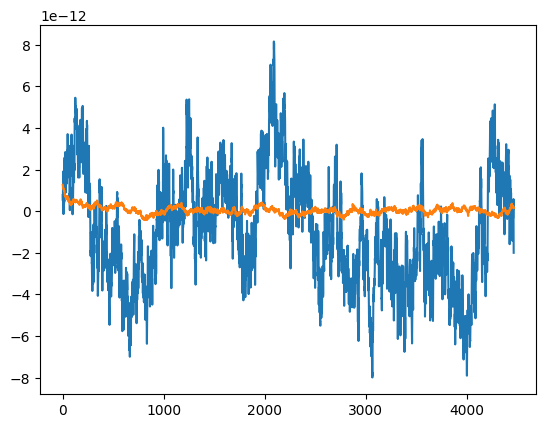

length of history is 4466
length of trace is 446663
speed idx sim: 215
total hist idx: 208
len of gamma mean 208


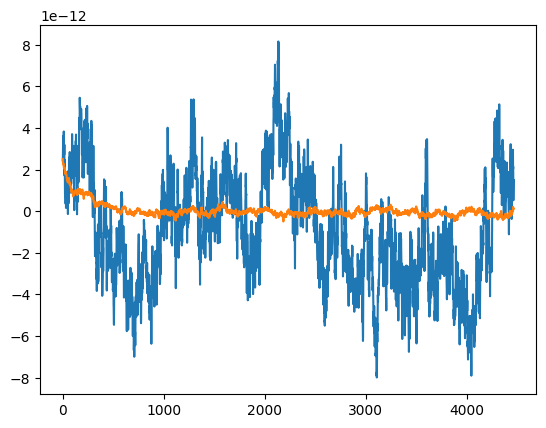

In [4]:
from scipy.integrate import simpson
from scipy.integrate import cumulative_simpson

print("sqrt kT/m is " + str(np.sqrt(constants.k*temp/mass)))
print("vel std is " + str(np.std(v_traces_sim[0])))
# SIM PART 2
vos = [-1, -.5, 0, .5, 1]
tol = .001

far = -4
close = -7.5

print(int(10**far*fs_sim))
print(len(v_traces_sim[0]))

times = np.logspace(close, far, 500)

far_boundary = 10**(far)
close_boundary = 10**(close)

hist_len = int(far_boundary*fs_sim)

sim_histories = []
first = True
all_forward_basset_by_parts = []
all_gamma = []
all_by_parts_hist_basset_integrals = []

# integrand = v / t**(1.5)

for speed in vos:
    v_0 = speed*np.sqrt(constants.k*temp/mass)
    print("length of history is " + str(hist_len) )
    print("length of trace is " + str(len(v_traces_sim[0])))
    speed_histories = []
    forward_basset_by_parts_main = []
    by_parts_hist_bassets_integrals_of_speed = []
    gamma_func_of_speed = []
    for i in range(len(traces_sim)):
        v_tolerance = (speed * np.sqrt(constants.k*temp/mass))
        speed_tolerance = tol * np.sqrt(constants.k*temp/mass)
        v_indices = np.where((v_traces_sim[i] < v_tolerance + speed_tolerance) & (v_traces_sim[i] > v_tolerance - speed_tolerance))[0]
        print("speed idx sim: " + str(len(v_indices)))

        hist_idx = []
        for idx in v_indices:
            if idx - hist_len > 0 and idx + int(10**far*fs_sim) < len(v_traces_sim[0]):
                hist_idx.append(idx)

        print("total hist idx: " + str(len(hist_idx)))

        for idx in hist_idx:
            v = v_traces_sim[i][idx - hist_len: idx][::-1]
            t_hist = np.linspace(0, far_boundary, len(v)) #np.arange(int(close_boundary*fs_sim), hist_len + 1)*(1/fs_sim)
            forward_basset_by_parts = []
            by_parts_hist_basset_integrals = []

            for t in times:
                integrand = v / (2*(t+t_hist)**(1.5))

                total = simpson(integrand, x=t_hist)
                forward_basset_by_parts.append(total)

                v_forward = v_traces_sim[i][idx: idx + int(t*fs_sim)]
                t_forward = np.arange(int(t*fs_sim))/fs_sim

                integrand_forward = v_forward/(2*(t-t_forward)**(1.5))
                total_forward = simpson(integrand_forward, x=t_forward)

                by_parts_hist_basset_integrals.append(total_forward)
            #
            # if first:
            #     plt.plot(times, 6*r**2*np.sqrt(np.pi * eta * rho_f)*np.array(decay_integrals))
            #     plt.axhline(mass*v_0)
            #     plt.xscale('log')
            #     plt.show()

            forward_basset_by_parts_main.append(forward_basset_by_parts)
            by_parts_hist_bassets_integrals_of_speed.append(by_parts_hist_basset_integrals)
            gamma_func_of_speed.append(6*np.pi*r*eta*v_traces_sim[i][idx+int(10**close*fs_sim):idx+int(10**far*fs_sim)])
            # integrand2 = v / (2*(t_hist)**(1.5))
            # total = simps(integrand2, t_hist)
            # cumlutive = cumtrapz(integrand2, t_hist)
            # speed_histories.append(total)
            #
            # if first:
            #     plt.plot(t_hist, v*1000, label = "scaled velocity")
            #     plt.plot(t_hist[1:], cumlutive, label = "cumulative integral")
            #     plt.axhline(total, label = "total integral")
            #     plt.xscale('log')
            #     plt.legend()
            #     plt.title("Log Scale")
            #     plt.show()
            #     plt.plot(t_hist, v*1000, label = "scaled velocity")
            #     plt.plot(t_hist[1:], cumlutive, label = "cumulative integral")
            #     plt.axhline(total, label = "total integral")
            #     plt.xscale('linear')
            #     plt.legend()
            #     plt.title("Linear Scale")
            #     plt.show()
            #     first = False
    # sim_histories.append(speed_histories)

    print("len of gamma mean " + str(len(gamma_func_of_speed)))
    plt.plot(gamma_func_of_speed[0])
    plt.plot(np.mean(gamma_func_of_speed, axis=0))
    plt.show()
    all_gamma.append(np.mean(gamma_func_of_speed, axis=0))
    all_forward_basset_by_parts.append(forward_basset_by_parts_main)
    all_by_parts_hist_basset_integrals.append(by_parts_hist_bassets_integrals_of_speed)
    # plt.hist(speed_histories, 100)
    # plt.title(f"Speed History {speed} STD")
    # plt.show()
    # print(6*r**2*np.sqrt(np.pi * eta * rho_f))
    # print((mass*v_0))
    # ratio = ((mass*v_0)+6*r**2*np.sqrt(np.pi * eta * rho_f)*np.mean(speed_histories))/(mass*v_0)
    # print("Ratio is " + str(ratio))


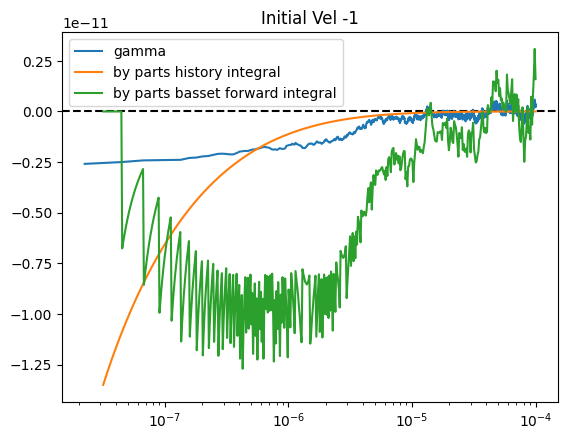

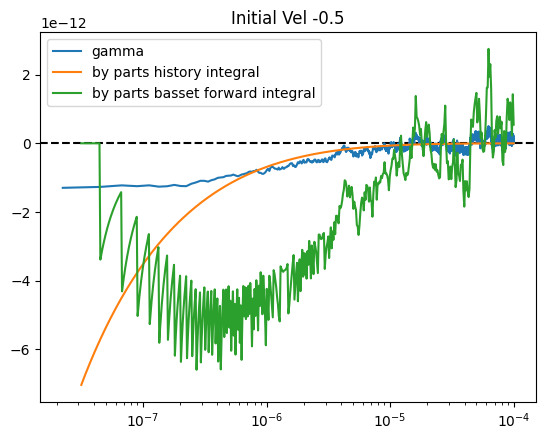

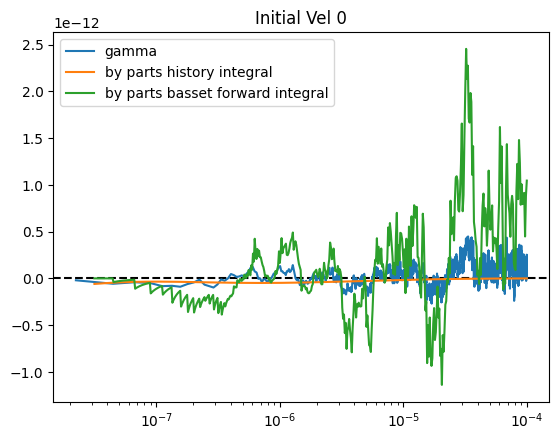

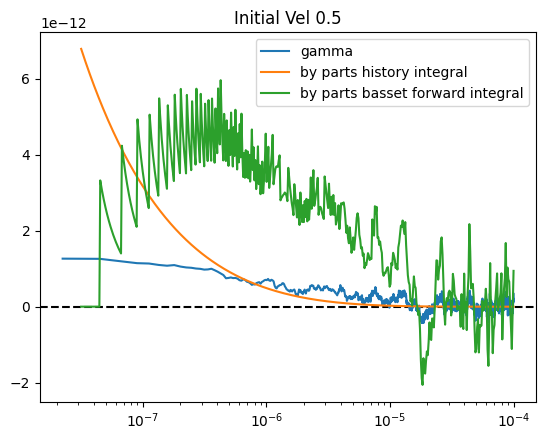

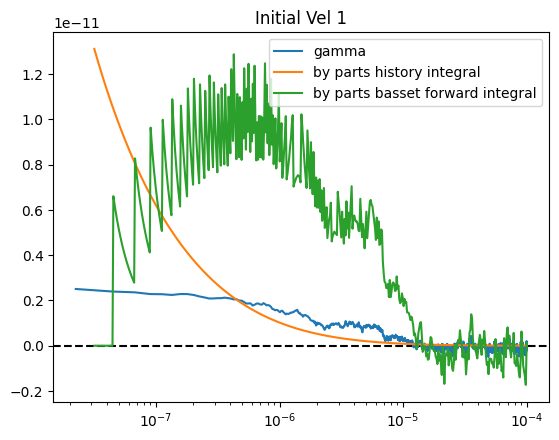

In [5]:

mean_forward_basset_by_parts = [np.mean(group, axis=0) for group in all_forward_basset_by_parts]
mean_by_parts_hist_arrays_basset = [np.mean(group, axis=0) for group in all_by_parts_hist_basset_integrals]

for i in range(len(mean_forward_basset_by_parts)):
    # v_0 = vos[i]*np.sqrt(constants.k*temp/mass)
    # force = mean_arrays[i]*6*r**2*np.sqrt(np.pi * eta * rho_f)
    # force_over_m = mean_arrays[i]*6*r**2*np.sqrt(np.pi * eta * rho_f)/mass
    # integrate = cumtrapz(force_over_m, times)
    # plt.plot(times[:-1], integrate, label="integrate")
    # plt.legend()
    # plt.axhline(v_0)
    # plt.show()
    gamma_times = np.arange(int(10**close*fs_sim), int(10**far*fs_sim))/fs_sim
    plt.axhline(0, color='black', ls='--')
    plt.plot(gamma_times, all_gamma[i], label='gamma')
    plt.plot(times, mean_forward_basset_by_parts[i] * 6 * r ** 2 * np.sqrt(np.pi * eta * rho_f), label ="by parts history integral")
    plt.plot(times, mean_by_parts_hist_arrays_basset[i] * 6 * r ** 2 * np.sqrt(np.pi * eta * rho_f), label ="by parts basset forward integral")
    plt.title(f"Initial Vel {vos[i]}")
    # plt.axhline(mass*v_0, color = 'red', label = "M*v_0")
    plt.xscale('log')
    # plt.xlim(right=5e-7)
    plt.legend()
    plt.show()
